Theano Tutorial @ LTI, Carnegie Mellon University
=======================

Kazuya Kawakami, clab

# Theano

Theano is a Python library, like numpy, that lets you to define mathematical expressions and run them on GPU.  
In short, Theano is the best prototyping tool!!

**Pros**

- **Python** : Preprocessing, Modeling, Visualization. Numpy like expression.
- **Easy to access GPU**: You don't need to do anything!!
- **Execution speed optimizations**: Theano can use g++ or nvcc to compile your expression graph
- **Symbolic differentiation**: Automatic Differentiation on symbolic expressions
- **Stability optimizations**: Theano recognize numerically unstable expressions and fix them
- **Still growing**: Developer communitiy is active

**Cons**

- **Loop** : Restrictions on how the loop interact with the rest of the graph
- ** Goto/Recursion**: are not supprted

## Contents
0. **Tools**: You don't need to know theano at all !! ( [nolearn](https://github.com/dnouri/nolearn.git), [Pylearn2](http://deeplearning.net/software/pylearn2/), [sklearn-theano](http://sklearn-theano.github.io/auto_examples/plot_mnist_generator.html#example-plot-mnist-generator-py) ).

1. **Overview**: How theano codes look like??
2. **Variables**: Symbolic variable, Shared variable
3. **Function, Computational Graph**: tensor.function, tensor.clone, theano.printing.pp, theano.printing.debugprint
4. **Math**:  Comparison, Condition
5. **Linear Algebra**
6. **Gradient**: theano.gradient.grad, theano.gradient.hessian, theano.gradient.jacobian, update
7. **GPU**: Data type 
8. **Linear Regression**
9. **Multi Layer Perceptron**
10. **Convolution**
11. **Maxpooling**
12. **Scan**
13. **Recurrent Neural Networks**
14. **Tips for debugging**
15. **Links**

##Server

This is a hands-on tutorial, if you sent your public key to Prasanna, you can log in to your server.
The server has 4 GPUs. To avoid all participants uses one gpu, please specify explicitly the gpu you want to use.

In [1]:
import theano.sandbox.cuda
theano.sandbox.cuda.use("gpu0") #gpu1, gpu2, gpu3

Using gpu device 0: GeForce GTX TITAN Black


If you are running command line, run your code with the following options.

```bash
THEANO_FLAGS=mode=FAST_RUN,device=gpu0,floatX=float32, python your_code.py
THEANO_FLAGS=mode=FAST_RUN,device=gpu1,floatX=float32, python your_code.py
THEANO_FLAGS=mode=FAST_RUN,device=gpu2,floatX=float32, python your_code.py
THEANO_FLAGS=mode=FAST_RUN,device=gpu3,floatX=float32, python your_code.py
```

To run your experiments with ipython notebook, you should write this in your ~/.ssh/config 

Host tutorial    
HostName [[[IP ADDRESS]]]    
User [[[USER NAME]]]    
LocalForward 8888 127.0.0.1:8888    

```bash
ssh tutorial
```

Then launch your ipython server by following this [Instruction](http://ipython.org/ipython-doc/1/interactive/public_server.html).

## Tools

There are a lots of tools implemented with Theano.
For example, [nolearn](https://github.com/dnouri/nolearn.git) let you write image classification in 30 lines !! 

More examples and tutorials are in [dl_tutorial](https://github.com/oduerr/dl_tutorial/tree/master/lasagne).

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
from collections import OrderedDict

import numpy
import theano
import theano.tensor as T

from sklearn.datasets import fetch_mldata
from sklearn.utils import shuffle
from sklearn.cross_validation import train_test_split
from sklearn.metrics import f1_score

#Random Seed
rng = numpy.random.RandomState(1234)

mnist = fetch_mldata('MNIST original')

# mnist_x is a (n_sample, n_feature=784) matrix
mnist_x, mnist_y = mnist.data.astype("float32")/255.0, mnist.target.astype("int32")

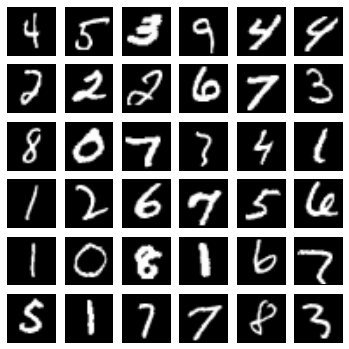

In [3]:
## Show Randomly picked Examples
def plot_sample(x, axis):
    img = x.reshape(28, 28)
    axis.imshow(img, cmap='gray')
    
fig = plt.figure(figsize=(6, 6))
for i in range(36):
    ax = fig.add_subplot(6, 6, i + 1, xticks=[], yticks=[])
    plot_sample(mnist_x[numpy.random.randint(0,60000)], ax)

# Neural Network with 648010 learnable parameters

## Layer information

  #  name     size
---  -------  -------
  0  input    1x28x28
  1  hidden1  500
  2  hidden2  500
  3  output   10

  epoch    train loss    valid loss    train/val    valid acc  dur
-------  ------------  ------------  -----------  -----------  ------
      1       0.86462       3.96558      0.21803      0.10426  14.01s
      2       0.96698       5.56005      0.17392      0.10547  12.81s
      3       0.92779       2.41471      0.38422      0.21967  14.54s
      4       0.77710       3.91885      0.19830      0.15497  13.74s
      5       0.87891       5.69673      0.15428      0.24744  14.38s
      6       0.81317       3.49051      0.23297      0.23534  13.49s
      7       0.87590       4.86817      0.17992      0.27003  11.94s
      8       1.03506       5.42487      0.19080      0.30234  12.79s
      9       0.78844       3.54112      0.22265      0.35298  12.21s
     10       0.70892       5.16522      0.

/home/ubuntu/anaconda/lib/python2.7/site-packages/lasagne/init.py:86: UserWarning: The uniform initializer no longer uses Glorot et al.'s approach to determine the bounds, but defaults to the range (-0.01, 0.01) instead. Please use the new GlorotUniform initializer to get the old behavior. GlorotUniform is now the default for all layers.
  warnings.warn("The uniform initializer no longer uses Glorot et al.'s "
/home/ubuntu/anaconda/lib/python2.7/site-packages/lasagne/layers/helper.py:69: UserWarning: get_all_layers() has been changed to return layers in topological order. The former implementation is still available as get_all_layers_old(), but will be removed before the first release of Lasagne. To ignore this warning, use `warnings.filterwarnings('ignore', '.*topo.*')`.
  warnings.warn("get_all_layers() has been changed to return layers in "


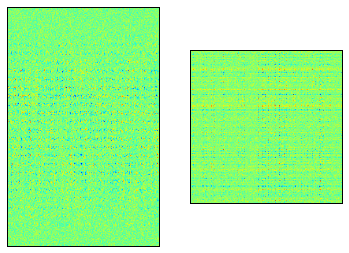

In [4]:
from lasagne import layers
from lasagne import nonlinearities
from nolearn.lasagne import NeuralNet

network = NeuralNet(
    #Define Layers
    layers=[
        ('input', layers.InputLayer),
        #('conv', layers.Conv2DLayer),
        #('pool', layers.MaxPool2DLayer),
        ('hidden1', layers.DenseLayer),
        #('dropout', layers.DropoutLayer),
        ('hidden2', layers.DenseLayer),
        ('output', layers.DenseLayer),
        ],
    #Hidden Unit Size, Activation Function
    input_shape=(None, 1, 28, 28),
    #conv_num_filters=5, conv_filter_size=(3, 3), pool_pool_size=(2, 2),
    hidden1_num_units=500, #854 
    hidden1_nonlinearity=nonlinearities.tanh,
    #dropout_p = 0.5,
    hidden2_num_units=500,
    output_num_units=10, 
    output_nonlinearity=nonlinearities.softmax,

    # learning rate parameters
    update_learning_rate=0.01,
    update_momentum=0.9,
    regression=False,
    max_epochs=50,
    verbose=1,

    # Training test-set split
    eval_size = 0.2
)

#Learn Parameters
X = mnist_x.reshape(-1, 1, 28, 28) # Reshape sample to 2D image to feed in nolearn.
y = mnist_y
net = network.fit(X, y)

#Visualize weights
weights = network.get_all_params()
hidden1_weight = weights[0].get_value()
hidden2_weight = weights[2].get_value()
#plt.imshow(hidden1_weight)
fig = plt.figure(figsize=(6, 6))
fig.add_subplot(121, xticks=[], yticks=[]).imshow(hidden1_weight)
fig.add_subplot(122, xticks=[], yticks=[]).imshow(hidden2_weight)

Cool!! however your research is not just simple classification/regression. You will need to implement your algorithm by yourself.

For example, following contents are **not** coverd in several libraries.
- **Layers**:  Embedding Layers, Maxout Layer, Recurrent Layer
- **Customized convolution**: k-max pooling
- **Different cost function**: hinge loss, huber loss, cosine similarity
- **Pretraining strategies**: pre-train network with different dataset
- **Transfer learning**: multiple objective function

## Overview of Theano code

1. Define Symbolic/Shared variables (**Variables**)
2. Construct a computational graph (**Math**)
3. Compile the graph (**Function**)
4. Run!!

In [5]:
# Linear Regression
import numpy
import theano
import theano.tensor as T

##  Step1. Define Symbolic / Shared Variables
x, t = T.fvector("x"), T.fvector("t") #input

W = theano.shared(rng.uniform(low=-0.08,high=0.08, size=(5, 3)), name="W") #variables that are shared over iteration: weight, bias
b =  theano.shared(numpy.zeros(3), name="bias")


## Step2. Define graph
y = T.dot(x, W) + b

cost = T.sum((y - t)**2) #Cost function

gW, gb = T.grad(cost, [W, b]) # Take gradient

updates =  OrderedDict({W: W-0.01*gW, b: b-0.01*gb}) # Set update expression in OrderedDict


## Step3. Compile graph
f = theano.function(inputs=[x, t], outputs=[cost, gW, gb], updates=updates, allow_input_downcast=True)


## Step4. Run!!
for epoch in range(5):
    cost, gW, gb = f([-2., -1., 1., 2., 3.], [.4, .3, .5])
    print "epoch:: %d, cost:: %.3f"%(epoch, cost)

epoch:: 0, cost:: 0.295
epoch:: 1, cost:: 0.106
epoch:: 2, cost:: 0.038
epoch:: 3, cost:: 0.014
epoch:: 4, cost:: 0.005


## Variables

In addition to numpy.ndarray, you need to know **Symbolic Variable** and **Shared Variable**.

- **Symbolic Variable** is a symbolic representation of quantities you want to use in functions. (Inputs)
- **Shared Variable** is a variable with **storage** that is shared between functions. (Weights, Data)

In [6]:
## Symbolic Variables 
a = T.iscalar("a")   # integer
b = T.fscalar("b")  # float scalar

x = T.fvector("x")  # float vector
X = T.fmatrix("X") # float matrix

## Shared Variable, store variables on cpu/gpu memory
W = theano.shared(numpy.array([0., 1., 2., 3., 4.]).astype("float32"), name="W")
bias  = theano.shared(numpy.float32(5), name="bias")

# Get Value from shared variable
print W.get_value() 

## Define symbolic graph
c = a + b
y = T.dot(x, W) + bias

## Print symbolic graph
print theano.pp(y)

##  Advanced:: You can replace some parts of computation graph with different variable
d = theano.clone(output=c, replace={b: y}) #replace "b" with "y"
print theano.pp(d)

[ 0.  1.  2.  3.  4.]
((x \dot HostFromGpu(W)) + bias)
(a + ((x \dot HostFromGpu(W)) + bias))


## Function

Compile symbolic graph into a function

** BE CAREFUL**:: YOU NEED TO USE int32 or float32, only computations with float32 data-type can be accelerated.

In [7]:
## Compile symbplic graph into callable functions
add = theano.function(inputs=[a, b], outputs=c)
linear = theano.function(inputs=[x], outputs=y)

## Call Functions
print add(1, 5)
print linear([0., 0., 0., 0., 1.]).astype("float32")

##Print function
theano.printing.debugprint(linear)

## Advanced :: You can evaluate symbolic graph without compilation
print c.eval({
                        a : numpy.int32(16), 
                        b : numpy.float32(12.10)
                     })

6.0
9.0
HostFromGpu [@A] ''   7
 |GpuElemwise{Add}[(0, 0)] [@B] ''   6
   |GpuDimShuffle{} [@C] ''   5
   | |GpuGemv{inplace} [@D] ''   4
   |   |GpuAlloc{memset_0=True} [@E] ''   2
   |   | |CudaNdarrayConstant{0.0} [@F]
   |   | |TensorConstant{1} [@G]
   |   |TensorConstant{1.0} [@H]
   |   |GpuDimShuffle{x,0} [@I] ''   1
   |   | |W [@J]
   |   |GpuFromHost [@K] ''   0
   |   | |x [@L]
   |   |TensorConstant{0.0} [@M]
   |GpuFromHost [@N] ''   3
     |bias [@O]
28.1000003815


## Math

Most mathmatic operations are similar to numpy. However, comparison operations have special form. [[Basics](http://deeplearning.net/software/theano/library/tensor/basic.html)]

 Condition operation is 
 ```python
 T.switch(condition, if true, if false)
 ```
 
 Comparison is 
 
 ```python
 T.gt(a, b) #Greater Than
 ```

In [8]:
x = T.fvector("x")

### Basic Math operation & Activation funcsions
exp_x = T.exp(x)
sigmoid_x = T.nnet.sigmoid(x)
tanh_x = T.tanh(x)

### Advanced:: condition and comparison
relu_x = T.switch(T.gt(x, 0), x, 0)

f = theano.function([x], [exp_x, sigmoid_x, tanh_x, relu_x])
f(numpy.array([-2., -1., 1., 2., 3.]).astype("float32"))

[array([  0.13533528,   0.36787945,   2.71828175,   7.38905621,  20.08553696], dtype=float32),
 array([ 0.11920292,  0.26894143,  0.7310586 ,  0.88079703,  0.95257413], dtype=float32),
 array([-0.96402758, -0.76159418,  0.76159418,  0.96402758,  0.99505478], dtype=float32),
 array([ 0.,  0.,  1.,  2.,  3.], dtype=float32)]

## Gradient (Automatic Differentiation)

You can define gradient symbolically. Amazing!!

If you want to use Jacobian or Hessian, use theano.gradient.jacobian,  theano.gradient.hessian.

In [9]:
# y = x ** 2
x = T.fscalar("x")
y = x ** 2
gy = theano.grad(cost=y, wrt=x) ## 2x

f = theano.function([x], [y, gy]) ## x**2, 2x
print f(10)

[array(100.0, dtype=float32), array(20.0, dtype=float32)]


**Updateing your parameters (shared variables)** is the key process, but it's a bit complicated.

Let's start from a toy example.

In [10]:
##Define a function which update t by 1 for each call.

t = theano.shared(numpy.int32(0))
increment = theano.function([], t, updates=OrderedDict({t: t+1}) ) #OrderedDict({before update: after update})
for i in range(5):
    t = increment()
    print t

0
1
2
3
4


In [11]:
# Linear Regression
from collections import OrderedDict
rng = numpy.random.RandomState(1234)

##  Step1. Define Symbolic / Shared Variables
x, t = T.fvector("x"), T.fvector("t") #inputs


W = theano.shared(rng.uniform(low=-0.08,high=0.08, size=(5, 3)), name="W") #variables that are shared over iterations
b =  theano.shared(numpy.zeros(3), name="bias")


## Step2. Define graph
y = T.dot(x, W) + b
#y = T.nnet.sigmoid(T.dot(x, W) + b)
#y = T.tanh(T.dot(x, W) + b)
cost = T.sum((y - t)**2)


gW, gb = T.grad(cost, [W, b]) # Take gradient

updates =  OrderedDict({W: W-0.01*gW, b: b-0.01*gb}) # Set update expression in OrderedDict


## Step3. Compile graph
f = theano.function(inputs=[x, t], outputs=[cost, gW, gb], updates=updates, allow_input_downcast=True)

## Step4. Run!!
for epoch in range(5):
    cost, gW, gb = f([-2., -1., 1., 2., 3.], [.4, .3, .5])
    print "epoch:: %d, cost:: %.3f"%(epoch, cost)

epoch:: 0, cost:: 0.295
epoch:: 1, cost:: 0.106
epoch:: 2, cost:: 0.038
epoch:: 3, cost:: 0.014
epoch:: 4, cost:: 0.005


**Since we have Autodiff, it's easy to change linear regression to non-linear regression.** Try it!!

## Multi Layer Perceptron (MLP) 

<img src="http://k-kawakami.com/img/mlp.png">

In [12]:
#Multi Layer Perceptron
class Layer:
    def __init__(self, in_dim, out_dim, function):
        self.in_dim = in_dim
        self.out_dim = out_dim
        self.function = function

        self.W = theano.shared(
                                                    rng.uniform(
                                                                low=-0.08, 
                                                                high=0.08, 
                                                                size=(in_dim, out_dim)
                                                    ).astype("float32"), name="W")
        self.b =  theano.shared(numpy.zeros(out_dim).astype("float32"), name="bias")
        
        self.params = [ self.W, self.b ]

    def fprop(self, x):
        h = self.function(T.dot(x, self.W)+self.b)
        self.h = h
        return h 

In [13]:
train_x, valid_x, train_y, valid_y = train_test_split(mnist_x, mnist_y, test_size=0.2, random_state=42)

In [15]:
x, t = T.fmatrix("x"), T.ivector("t")
activation = T.nnet.sigmoid #T.tanh

layers = [
    Layer(784, 500, activation),
    Layer(500, 500, activation),
    Layer(500, 500, activation),
    Layer(500, 10, T.nnet.softmax)
]

## Collect Parameters and Symbolic output
params = []
for i, layer in enumerate(layers):
    params += layer.params
    if i == 0:
        layer_out = layer.fprop(x)
    else:
        layer_out = layer.fprop(layer_out)

        
## Cost Function (Negative Log Likelihood)
y = layers[-1].h
cost = - T.mean((T.log(y))[T.arange(x.shape[0]), t])


## Gradient
gparams = T.grad(cost, params)
gmomentums = [theano.shared(numpy.zeros_like(param.get_value(borrow=True)).astype("float32")) for param in params]
updates = OrderedDict()


## Defile Learning Rule, you can add Adagrad, Adadelta etc.
lr, momentum = numpy.float32(0.1), numpy.float32(0.9)

for param, gparam, gmomentum in zip(params, gparams, gmomentums,):
    #Clip gradient
    #gparam = theano.gradient.grad_clip(gparam, lower_bound=-5, upper_bound=5)

    # sgd
    #updates[param] = param - lr * gparam

    # momentum
    updates[gmomentum] = momentum * gmomentum - lr * gparam
    updates[param] = param + updates[gmomentum]

              
## Compile 
train = theano.function([x,t],cost,updates=updates)
test = theano.function([x,t],[cost, T.argmax(y, axis=1)])


## Iterate
batch_size = 100
nbatches = train_x.shape[0]//batch_size
for epoch in range(50):
    train_x, train_y = shuffle(train_x, train_y)  # Shuffle Samples !!
    for i in range(nbatches):
            start = i * batch_size
            end = start + batch_size
            train(train_x[start:end], train_y[start:end])
    valid_cost, pred = test(valid_x, valid_y)
    if (epoch + 1) % 10 == 0:
        print "EPOCH:: %i, Validation cost: %.3f, Validation F1: %.3f"%(epoch+1, valid_cost, f1_score(valid_y, pred, average="macro"))

EPOCH:: 10, Validation cost: 0.105, Validation F1: 0.970
EPOCH:: 20, Validation cost: 0.100, Validation F1: 0.974
EPOCH:: 30, Validation cost: 0.095, Validation F1: 0.979
EPOCH:: 40, Validation cost: 0.098, Validation F1: 0.980
EPOCH:: 50, Validation cost: 0.103, Validation F1: 0.980


####Exercises: Squeeze out the last few percent!!
1. Try other objectives, MSE, Cross Entropy. 
2. Try symmetric activation functions (tanh, softsign).
3. Implement ReLU (Hint. look at Math section).
4. Add Dropout (Hint. apply random mask to inputs in fprop).
5. Add learning rate adjuster (Hint. make learning rate as shared variable).

<img src="https://imiloainf.files.wordpress.com/2013/11/activation_funcs1.png"> [source]("https://imiloainf.wordpress.com/2013/11/06/rectifier-nonlinearities/")

## Convolution

1D convolution.
$$(f*g)(n) = \sum_{u=-\infty}^{+\infty} f(u) g(n-u) = \sum_{u=-\infty}^{+\infty} f(n-u) g(u)$$

<!--img src="https://upload.wikimedia.org/wikipedia/commons/6/6a/Convolution_of_box_signal_with_itself2.gif"-->

2D convolution.
$$(f*g)(m,n) = \sum_{u=-\infty}^{+\infty} \sum_{v=-\infty}^{+\infty} f(u,v) g(m-u,n-v)$$

Narrow Convolution
<img src="http://ufldl.stanford.edu/wiki/images/6/6c/Convolution_schematic.gif">

Images :: [wiki](https://en.wikipedia.org/wiki/Convolution), [Stanford UFLDL Tutorial](http://ufldl.stanford.edu/wiki/index.php/Feature_extraction_using_convolution)

In [16]:
from theano.tensor.nnet import conv

x = T.fmatrix('x')

##Prepare 3 * 3 line detector and reshape it to (number of filters=1, num input feature maps=1, filter height=3, filter width=3)
W = numpy.array([[1,0,1],[0,1,0],[1,0,1]]).astype("float32").reshape(1, 1, 3, 3)

##Reshape x to 2 * 2 image and convert it to (batch size=1, num input feature maps=1, image height, image width)
## if your image is RGB, num input feature maps=3

#Narrow Convolution
narrow_convoluted_image = conv.conv2d(x.reshape((1, 1, 5, 5)), W, border_mode="valid")
#Wide Convolution
wide_convoluted_image = conv.conv2d(x.reshape((1, 1, 5, 5)), W, border_mode="full")

## Convolution Function
narrow_convolution = theano.function([x], narrow_convoluted_image)
wide_convolution = theano.function([x], wide_convoluted_image)

## Sample Image
sample_image = numpy.array([[1., 1., 1., 0., 0.], [0., 1., 1., 1., 0.], [0., 0., 1., 1., 1.], [0., 0., 1., 1., 0.], [0., 1., 1., 0., 0.]]).astype("float32")

#Original Image
print sample_image

#Convolved Image
narrow_convoluted_image = narrow_convolution(sample_image).reshape(3, 3)
wide_convoluted_image = wide_convolution(sample_image).reshape(7, 7)
print narrow_convoluted_image
print wide_convoluted_image

[[ 1.  1.  1.  0.  0.]
 [ 0.  1.  1.  1.  0.]
 [ 0.  0.  1.  1.  1.]
 [ 0.  0.  1.  1.  0.]
 [ 0.  1.  1.  0.  0.]]
[[ 4.  3.  4.]
 [ 2.  4.  3.]
 [ 2.  3.  4.]]
[[ 1.  1.  2.  1.  1.  0.  0.]
 [ 0.  2.  2.  3.  1.  1.  0.]
 [ 1.  1.  4.  3.  4.  1.  1.]
 [ 0.  1.  2.  4.  3.  3.  0.]
 [ 0.  1.  2.  3.  4.  1.  1.]
 [ 0.  0.  2.  2.  1.  1.  0.]
 [ 0.  1.  1.  1.  1.  0.  0.]]


## Maxpooling

Maxpooling provides robustness to position and reduce dimensions.

In [17]:
from theano.tensor.nnet import conv
from theano.tensor.signal import downsample

x = T.fmatrix('x')

##Prepare 3 * 3 line detector and reshape it to (number of filters=1, num input feature maps=1, filter height=3, filter width=3)
W = numpy.array([[1,0,1],[0,1,0],[1,0,1]]).astype("float32").reshape(1, 1, 3, 3)

##Narrow Convolution
narrow_convoluted_image = conv.conv2d(x.reshape((1, 1, 5, 5)), W, border_mode="valid")

##Pooling  ds take pooling size
pooled_image1 = downsample.max_pool_2d(input=narrow_convoluted_image, ds=(1,3), ignore_border=True)
pooled_image2 = downsample.max_pool_2d(input=narrow_convoluted_image, ds=(1,2), ignore_border=False)
pooled_image3 = downsample.max_pool_2d(input=narrow_convoluted_image, ds=(3,3), ignore_border=False)
mean_pooled_image = T.mean(narrow_convoluted_image, axis=3) #Take mean over row

pooling = theano.function([x], [pooled_image1, pooled_image2, pooled_image3, mean_pooled_image ])

##Print Results
pooled_image = pooling(sample_image)
print pooled_image[0].reshape(3,1)
print pooled_image[1].reshape(3,2)
print pooled_image[2].reshape(1,1)
print pooled_image[3].reshape(3, 1)

[[ 4.]
 [ 4.]
 [ 4.]]
[[ 4.  4.]
 [ 4.  3.]
 [ 3.  4.]]
[[ 4.]]
[[ 3.66666675]
 [ 3.        ]
 [ 3.        ]]


## Scan

Scan is a special function for implementing loop in theano and it's a bit complicated.

In [18]:
##Suppose you have a sequence [1, 2, 3, 4, 5] let's define identity function with scan
x = T.fvector("x")

def step(x):
    return x

h, _ = theano.scan(
                       fn=step,
                       sequences=x, 
                       outputs_info=None
                    )

f = theano.function([x], h)

print f(numpy.array([1, 2, 3, 4, 5]).astype("float32"))

[ 1.  2.  3.  4.  5.]


/home/ubuntu/anaconda/lib/python2.7/site-packages/theano/scan_module/scan_perform_ext.py:133: RuntimeWarning: numpy.ndarray size changed, may indicate binary incompatibility
  from scan_perform.scan_perform import *


In [19]:
##Next we define accumulation function
x = T.fvector("x")

def step(x, h_tm1):
    return x + h_tm1

h, _ = theano.scan(
                       fn=step,
                       sequences=x, 
                       outputs_info=0.0, #Initial value for h
                       #go_backwards=True #you might use it for bi-directional RNNs
                    )

f = theano.function([x], h)

print f(numpy.array([1, 2, 3, 4, 5]).astype("float32"))

[  1.   3.   6.  10.  15.]


In [20]:
## Let's do the same thing with matrix, accumulation over column
x = T.fmatrix("x")

def step(x, h_tm1):
    return x + h_tm1

h, _ = theano.scan(
                       fn=step,
                       sequences=x, 
                       outputs_info=numpy.array([0., 0., 0., 0., 0.]) #Initial value for h, it's better to use T.alloc().
                    )

f = theano.function([x], h)

print f(numpy.array([[1, 2, 3, 4, 5], [1, 2, 3, 4, 5], [1, 2, 3, 4, 5]]).astype("float32"))

[[  1.   2.   3.   4.   5.]
 [  2.   4.   6.   8.  10.]
 [  3.   6.   9.  12.  15.]]


In [21]:
## Advanced :: take previous inputs
x = T.fmatrix("x")

def step(x, h_tm1, h_tm2):
    return x + h_tm1 + h_tm2

h, _ = theano.scan(
                       fn=step,
                       sequences=[ dict(input= x, taps = [0, -1, -2])],
                       outputs_info=None #Initial value for h
                    )

f = theano.function([x], h)

print f(numpy.array([[1, 2, 3, 4, 5], [1, 2, 3, 4, 5], [1, 2, 3, 4, 5],[1, 2, 3, 4, 5], [1, 2, 3, 4, 5]]).astype("float32"))

[[  3.   6.   9.  12.  15.]
 [  3.   6.   9.  12.  15.]
 [  3.   6.   9.  12.  15.]]


## Recurrent Networks

Once you could understand scan operation, it's easy to implement RNNs.

In [22]:
x = T.fmatrix("x")

##Define Shared variables
W_in = theano.shared(rng.uniform(low=-0.08, high=0.08, size=(5, 3)).astype("float32"), name="W_in")
W_rec = theano.shared(rng.uniform(low=-0.08, high=0.08, size=(3, 3)).astype("float32"), name="W_rec")
b = theano.shared(numpy.zeros(3).astype("float32"), name="bias")

def step(x, h_tm1, W_in, W_rec, b):
    return T.nnet.sigmoid(T.dot(x, W_in)+ T.dot(h_tm1, W_rec) + b)

h, _ = theano.scan(
                       fn=step,
                       sequences=x,
                       outputs_info=numpy.array([0., 0., 0.]), #Initial value for h
                       non_sequences=[W_in, W_rec, b] #Static variables
                    )

f = theano.function([x], h)

print f(numpy.array([[1, 2, 3, 4, 5], [1, 2, 3, 4, 5], [1, 2, 3, 4, 5],[1, 2, 3, 4, 5], [1, 2, 3, 4, 5]]).astype("float32"))

[[ 0.5428413   0.43146944  0.46239575]
 [ 0.56120373  0.42967877  0.46901187]
 [ 0.56145015  0.42942136  0.46932794]
 [ 0.56145379  0.4294191   0.46933278]
 [ 0.56145387  0.42941908  0.46933284]]


#### Exercises

1. Implement Convolution Layer, Maxpooling Layer
2. Implement RNNs
3. Try different configurations including various convolutions and poolings and see their performances

## Tips for debugging

1. Check data type. You should use "int32", "float32".
2. Check matrix size
3. Check your graph is defined correctly with debug print (DisconnectedInputError, UnusedINputError)
4. Ask developers [Forum](https://groups.google.com/forum/#!forum/theano-users)
5. E-mail me ;)

## Links

Lectures

- [Toronto University, Neural Networks for Machine Learning](https://www.coursera.org/course/neuralnets) by Geoffrey Hinton
- [New York University, Deep Learning](http://techtalks.tv/deep-learning-nyu-spring-2015/) by Yann Lecun
- [Oxford University, Deep Learning](https://www.youtube.com/playlist?list=PLE6Wd9FR--EfW8dtjAuPoTuPcqmOV53Fu) by Nando de Freitas
- [Stanford University, Convolutional Neural Networks for Visual Recognition](http://cs231n.stanford.edu/) by Fei-Fei Li, Andrej Karpathy
- [Stanford University, Deep Learning for NLP](http://cs224d.stanford.edu/) by Richard Socher
- [Université de Sherbrooke, Neural networks](https://www.youtube.com/playlist?list=PL6Xpj9I5qXYEcOhn7TqghAJ6NAPrNmUBH) by  Hugo Larochelle

Website
- [deeplearning.net](http://deeplearning.net/)

Tutorials
- [Deep Learning Tutorial](http://deeplearning.net/tutorial/)

Books
- [Deep Learning](http://www.iro.umontreal.ca/~bengioy/dlbook") Yoshua Bengio, Ian Goodfellow, Aaron Courville, MIT Press, In preparation.

## References
1. [Theano Documentation](http://deeplearning.net/software/theano/introduction.html)
2. [Deep Learning Tutorial](http://deeplearning.net/tutorial/)
3. F. Bastien, P. Lamblin, R. Pascanu, J. Bergstra, I. Goodfellow, A. Bergeron, N. Bouchard, D. Warde-Farley and Y. Bengio. [Theano: new features nd speed improvements"](http://arxiv.org/pdf/1211.5590.pdf). NIPS 2012 deep learning workshop.
4. J. Bergstra, O. Breuleux, F. Bastien, P. Lamblin, R. Pascanu, G. Desjardins, J. Turian, D. Warde-Farley and Y. Bengio. [Theano: A CPU and GPU Math Expression Compiler](http://www.iro.umontreal.ca/~lisa/pointeurs/theano_scipy2010.pdf). Proceedings of the Python for Scientific Computing Conference (SciPy) 2010. June 30 - July 3, Austin, TX
5. [Wikipedia, Convolution](https://en.wikipedia.org/wiki/Convolution)
6. [Stanford UFLDL Tutorial](http://ufldl.stanford.edu/wiki/index.php/UFLDL_Tutorial)

## Acknowledgements

Thank you Guillaume Lample, Ramón Fernandez Astudillo, Chu-Cheng Lin for reviewing this tutorial. 

And I appreciate Theano developers!!!